In [1]:
from keras import backend as K
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

def weighted_loss(y_true, y_pred):
    # Calculate the base loss
    ce = K.sparse_categorical_crossentropy(y_true, y_pred)
    # Apply the weights
    one_weight = 1.0
    zero_weight = 1e-2
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weight_vector = K.squeeze(weight_vector, axis=-1)
    weighted_ce = weight_vector * ce

    # Return the mean error
    return K.mean(weighted_ce)

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from tensorflow import keras

from tiling_augmentation import HubmapOrgan
from unet_models import unet_basic

BATCH_SIZE = 4
IMG_SIZE = 512
STRIDE_SIZE = None
THRESHOLD = 0.2

In [26]:
model = unet_basic(IMG_SIZE, 1)
model.compile(loss=bce_dice_loss,
              optimizer=keras.optimizers.Adam(5e-4),
              metrics=['accuracy', dice_coef, iou_coef])
#model.summary()

In [3]:
train_gen = HubmapOrgan(batch_size=BATCH_SIZE,
                        tile_size = IMG_SIZE,
                        stride=STRIDE_SIZE, 
                        dataset="train", 
                        img_type="png", 
                        shuffle=False)
validation_gen = HubmapOrgan(batch_size=BATCH_SIZE, 
                             tile_size=IMG_SIZE, 
                             stride=STRIDE_SIZE,  
                             dataset="validation", 
                             img_type="png", 
                             shuffle=False)

In [27]:


callbacks = [keras.callbacks.ModelCheckpoint('mymodel1', save_best_only=True)]
history = model.fit(train_gen,
                    epochs=2,
                    validation_data=validation_gen,
                    callbacks=callbacks)

Epoch 1/2
60/60 [==============================] - ETA: 0s - loss: 0.8255 - accuracy: 0.8963 - dice_coef: 0.1270 - iou_coef: 0.0403  

INFO:tensorflow:Assets written to: mymodel1\assets


INFO:tensorflow:Assets written to: mymodel1\assets


60/60 [==============================] - 6657s 111s/step - loss: 0.8255 - accuracy: 0.8963 - dice_coef: 0.1270 - iou_coef: 0.0403 - val_loss: 0.7194 - val_accuracy: 0.9139 - val_dice_coef: 0.1157 - val_iou_coef: 0.0283
Epoch 2/2
60/60 [==============================] - 6608s 110s/step - loss: 0.8052 - accuracy: 0.9045 - dice_coef: 0.1283 - iou_coef: 0.0387 - val_loss: 0.7323 - val_accuracy: 0.9139 - val_dice_coef: 0.1345 - val_iou_coef: 0.0373


### Prediction

In [35]:
a = HubmapOrgan(batch_size=10, tile_size = 512, stride=None,  dataset="validation", img_type="png", shuffle=False)
images, masks = a[0]

img_test = images[:36]
mask_test = masks[:36]

model = keras.models.load_model('mymodel1', compile=False)

mask_predict = model.predict(img_test)
mask_predict=np.where(mask_predict > THRESHOLD, 1,0)

2/2 [==============================] - 7s 826ms/step


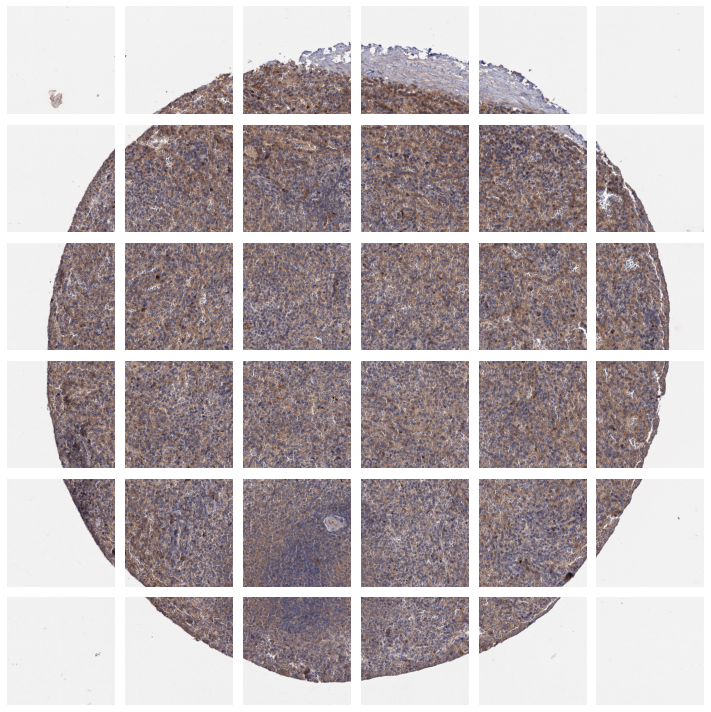

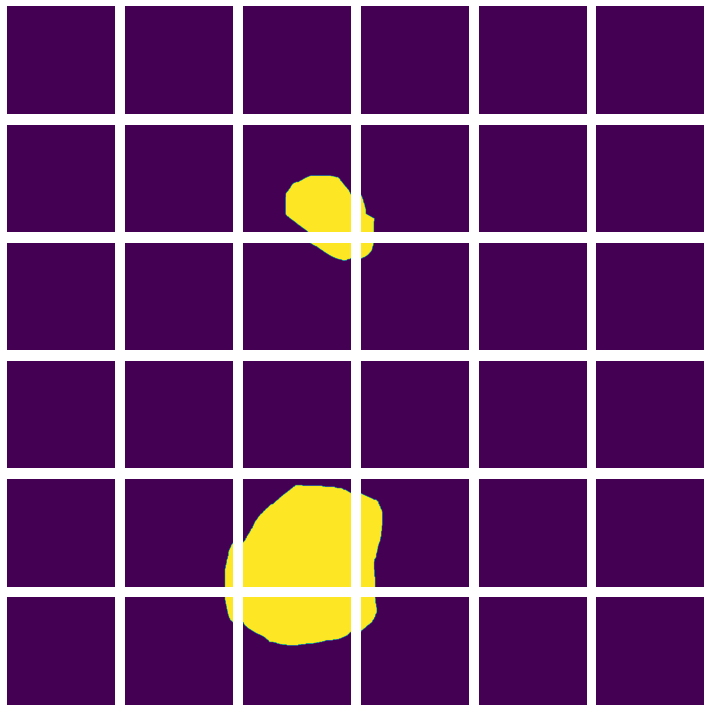

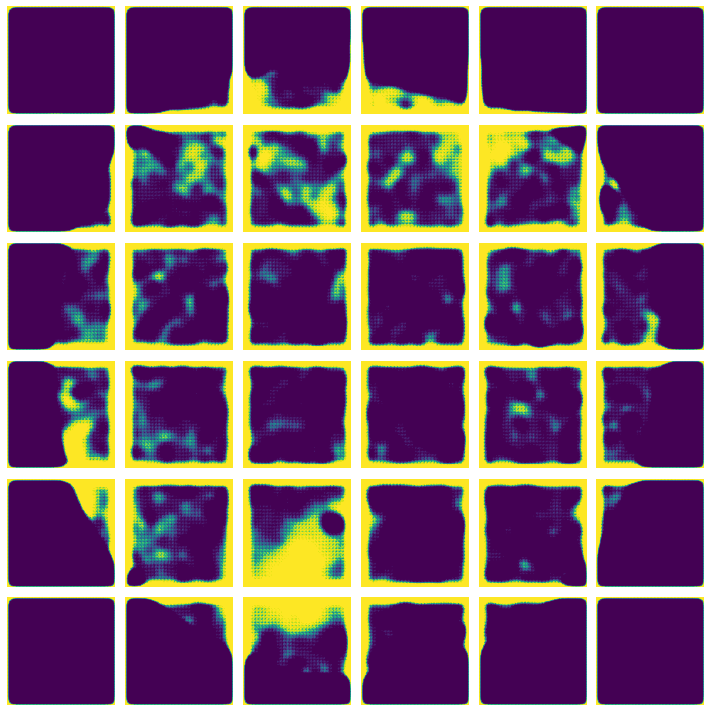

In [36]:
plt.figure(figsize=(10,10))
for i, img_crop in enumerate(img_test):
    plt.subplot(int(len(img_test)**0.5), int(len(img_test)**0.5),i+1)
    plt.imshow(img_crop)
    plt.axis(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
for i, mask_crop in enumerate(mask_test):
    plt.subplot(int(len(mask_test)**0.5), int(len(mask_test)**0.5),i+1)
    plt.imshow(mask_crop)
    plt.axis(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
for i, mask_crop in enumerate(mask_predict):
    plt.subplot(int(len(mask_predict)**0.5), int(len(mask_predict)**0.5),i+1)
    plt.imshow(mask_crop)
    plt.axis(False)

plt.tight_layout()
plt.show()